# 2D post processing

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib, shlex, subprocess
import xbout
import scipy
import xhermes
from xhermes import *


sys.path.append(r"/users/jpm590/2dspace/post-processing/sdtools/")


from hermes3.utils import *


from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.selectors import *

%load_ext autoreload
%autoreload 2
print("Done")
import hermes3



Done


## Read Hermes-3

name = whatever you want to name the case

id = the folder name of the case

In [2]:
db = CaseDB(
    case_dir = r"/users/jpm590/2dspace/run",
    grid_dir = r"/users/jpm590/2dspace/hermes-3/build-mc-master"
)

toload = [
    dict(name="MAST-U", id="251007-2D-MASTU", unnormalise_geom = True, use_xhermes = True, squash = True)
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()
    

- Reading case 251007-2D-MASTU
-----------------------
- Looking for squash file
- Squash file found. squash date 10/17/2025, 15:41:40, dmp file date 10/16/2025, 00:59:55

Unnormalising with xHermes


In [1]:
# print(f'Species in model: \n {m["species"]}')
# print(f'\nCharged species: \n {m["charged_species"]}')
# ds = cs["251007-2D-MASTU"].ds.isel(t=-1)

m = cs["MAST-U"].ds.metadata
m

NameError: name 'cs' is not defined

To access the functions under `hermesm`, see [accessors.py](https://github.com/mikekryjak/sdtools/blob/4242b6f0a55edf66d0b6e6f706bb7dc8515eb143/hermes3/accessors.py#L9)

`select_custom_sol_ring`: to create custom SOL ring beyond the separatrix.

 - `sepadd`: the number of cells beyond the first cell center outside of separatrix

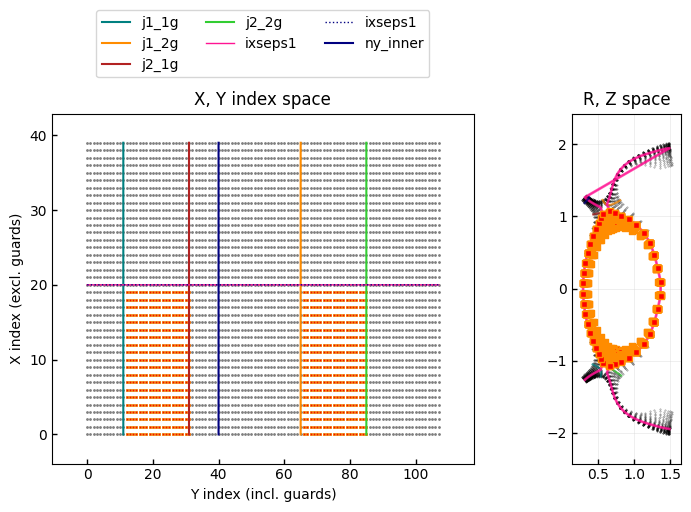

In [4]:
ds = cs["MAST-U"].ds.isel(t=-1)
plot_selection(ds, ds.hermesm.select_region("core"))


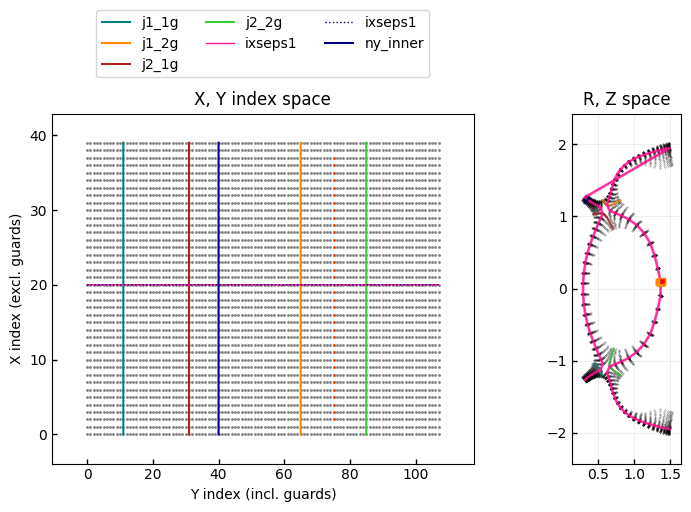

In [5]:
plot_selection(ds, ds.hermesm.select_region("outer_midplane_a"))


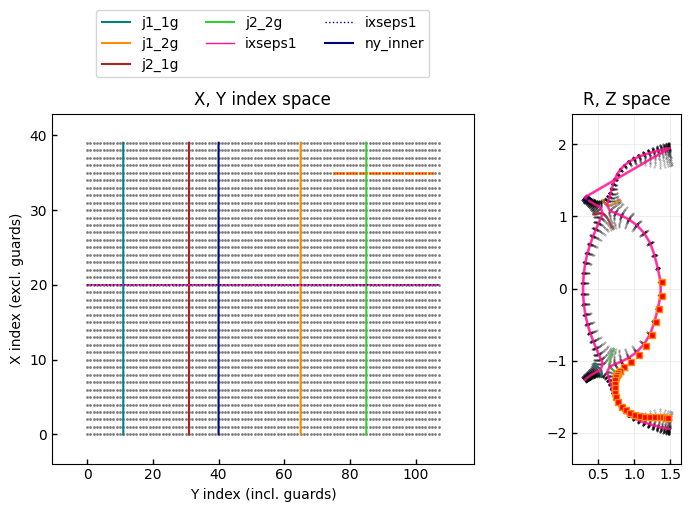

In [6]:
plot_selection(ds, ds.hermesm.select_custom_sol_ring(sepadd = 15, region="outer_lower"))


### Using selection to plot quantities of interest
#### Plot of separatrix density time evolution

Text(0.5, 1.0, 'Separatrix density evolution')

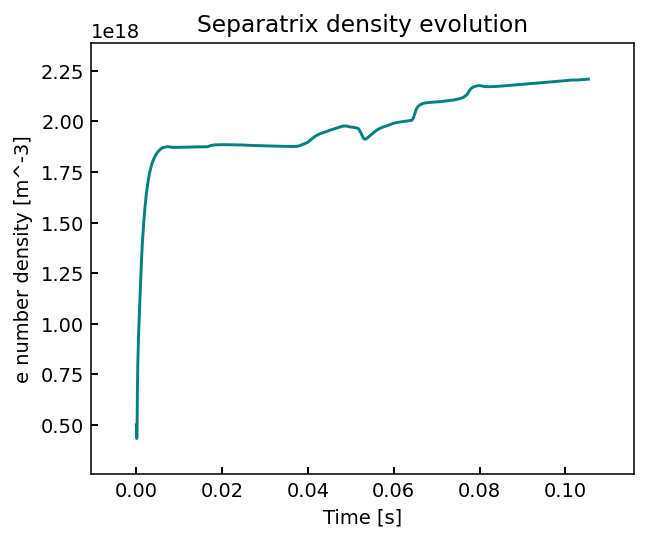

In [7]:
ds = cs["MAST-U"].ds
ds.hermesm.select_region("outer_midplane_a_sep")["Ne"].plot()
plt.title("Separatrix density evolution")


### Plot target temperature history

- guard cells are included by default

Text(0.5, 1.0, 'Target temperature history')

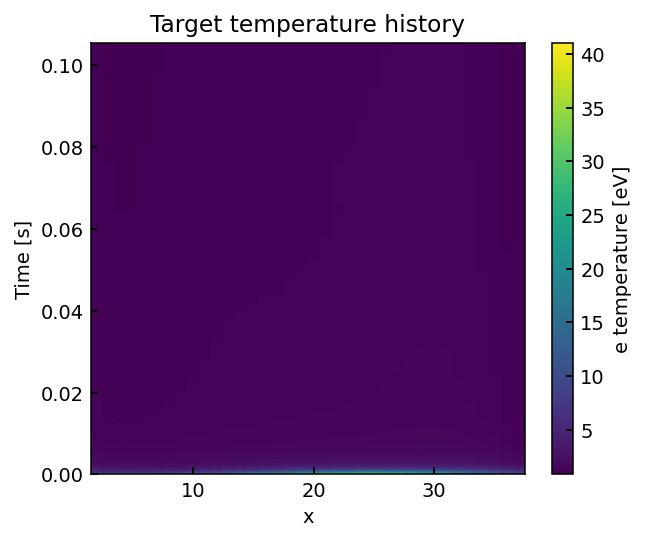

In [8]:
ds = cs["MAST-U"].ds
ds.hermesm.select_region("outer_lower_target")["Te"].plot()
plt.title("Target temperature history")

### Plotting radial and poloidal information
#### get 1d poloidal data


,R,Z,dpol,Bxy,Bpxy,Te,Td+,Td,dpar,Spol,Spar
26,1.275135,-1.680262,0.077293,0.371020,0.018840,1.932889,1.670417,1.901985,1.522119,2.255631,13.074304
27,1.359630,-1.666703,0.081238,0.347776,0.013513,1.417202,1.465737,1.723508,2.090819,2.336869,15.165123
28,1.423559,-1.681759,0.053467,0.332298,0.016092,1.152827,1.408581,1.620763,1.104052,2.390335,16.269175
29,1.466046,-1.694263,0.036847,0.322755,0.017341,0.992746,1.314244,1.478126,0.685806,2.427183,16.954981
30,1.495209,-1.702641,0.024396,0.316512,0.017949,0.845318,1.125156,1.192155,0.430198,2.451578,17.385179


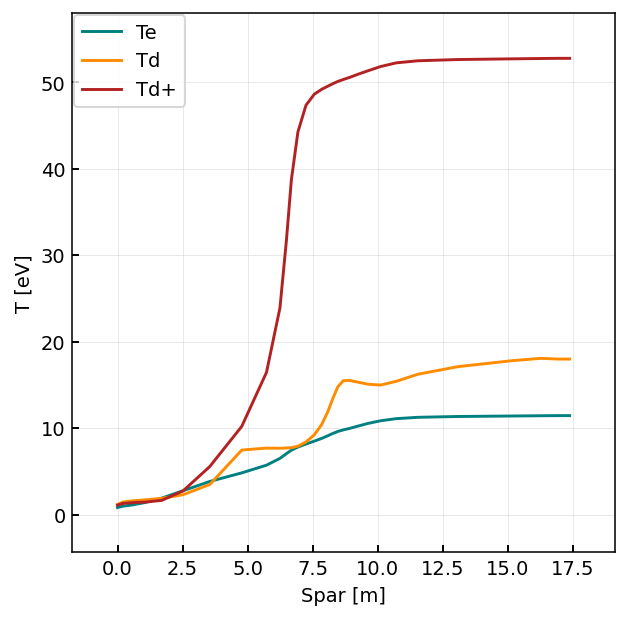

In [9]:
ds = cs["MAST-U"].ds.isel(t=-1)
df_fieldline = get_1d_poloidal_data(ds, params = ["Te", "Td+", "Td"], region = "outer_lower", sepadd=19)
display(df_fieldline.tail(5))

fig, ax = plt.subplots(figsize = (5,5))
ax.plot(df_fieldline["Spar"].values[::-1], df_fieldline["Te"], label = "Te")
ax.plot(df_fieldline["Spar"].values[::-1], df_fieldline["Td"], label = "Td")
ax.plot(df_fieldline["Spar"].values[::-1], df_fieldline["Td+"], label = "Td+")
ax.set_xlabel("Spar [m]")
ax.set_ylabel("T [eV]")
ax.legend()
ax.grid(True, alpha=0.5)

,R,Z,dpol,Bxy,Bpxy,Sd+_iz,Sd+_rec,Fdd+_cx,dpar,Spol,Spar
26,1.288741,-1.777602,0.064839,0.367306,0.022288,4.714324e+21,-1.031175e+19,2.075115,1.068562,2.310931,14.042461
27,1.350686,-1.781279,0.058007,0.350335,0.019080,1.079242e+21,-1.378463e+19,0.787831,1.065100,2.368938,15.107561
28,1.403256,-1.787911,0.047520,0.337187,0.017925,3.344765e+20,-1.670678e+19,-0.813365,0.893899,2.416458,16.001460
29,1.444624,-1.794509,0.036270,0.327540,0.017575,1.238651e+20,-1.895614e+19,-11.877119,0.675947,2.452728,16.677407
30,1.474918,-1.799478,0.025163,0.320826,0.017467,3.127132e+19,-2.148721e+19,58.334279,0.462195,2.477891,17.139602


Text(0, 0.5, 'momentum trasnfer rate [kg m-2 s-2]')

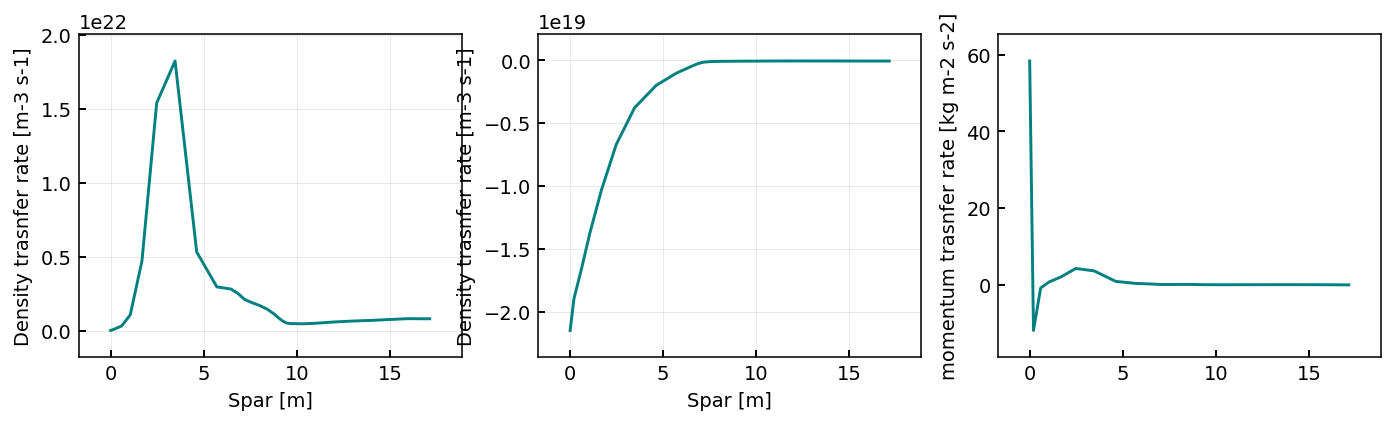

In [10]:
ds = cs["MAST-U"].ds.isel(t=-1)
df_fieldline = get_1d_poloidal_data(ds, params = ["Sd+_iz", "Sd+_rec", "Fdd+_cx"], region = "outer_lower", sepadd=15)
display(df_fieldline.tail(5))

fig, ax = plt.subplots(1, 3,figsize = (12,3))
ax[0].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Sd+_iz"])
ax[1].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Sd+_rec"])
ax[2].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Fdd+_cx"])

for i in range(0, 2):
    ax[i].set_xlabel("Spar [m]")
    ax[i].grid(True, alpha=0.5)

ax[0].set_ylabel("Density trasnfer rate [m-3 s-1]")
ax[1].set_ylabel("Density trasnfer rate [m-3 s-1]")
ax[2].set_ylabel("momentum trasnfer rate [kg m-2 s-2]")



,dr,Sd+_iz,Sd+_rec,Fdd+_cx,Srad,sep
31,0.016545,1.287922e+20,-4.120118e+19,85.685043,0.108319,0
32,0.018412,7.255728e+19,-3.088368e+19,72.845659,0.125798,0
33,0.020393,3.127132e+19,-2.148721e+19,58.334279,0.145200,0
34,0.022483,8.617602e+18,-1.334916e+19,42.542133,0.166638,0
35,0.024686,9.839967e+17,-6.384860e+18,25.592618,0.190222,0


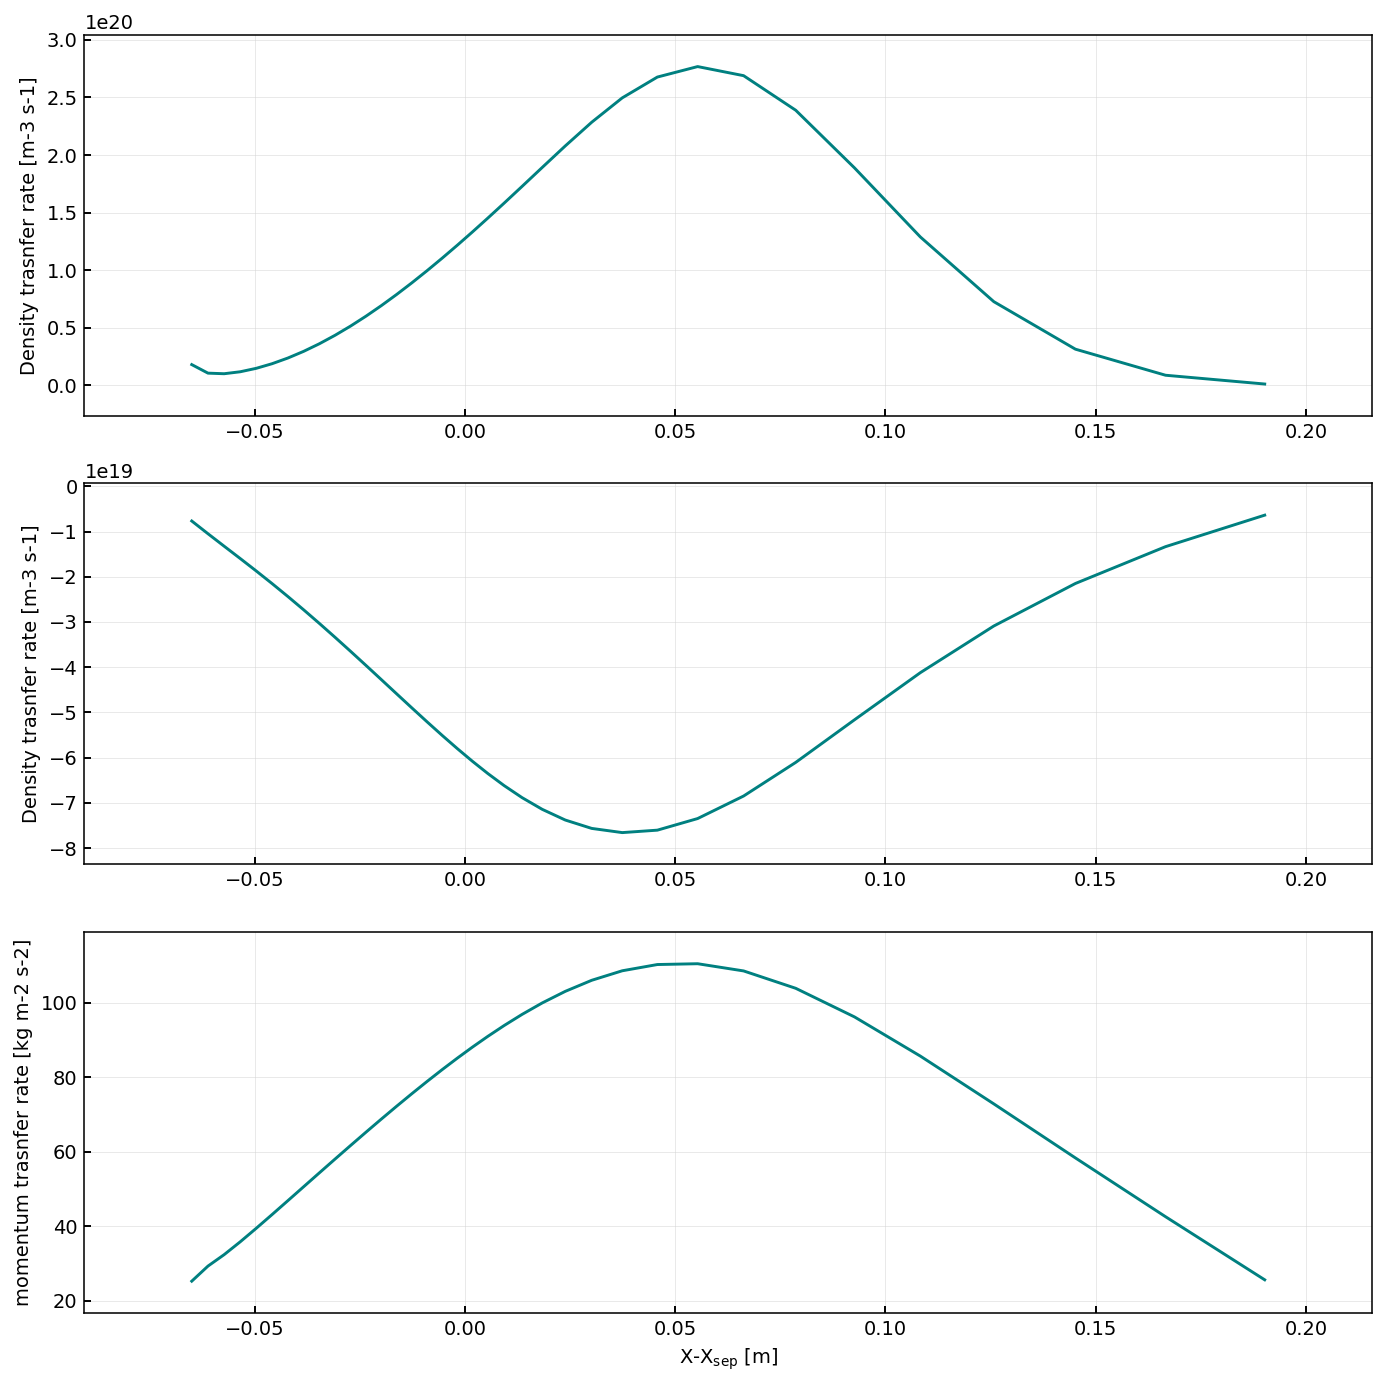

In [11]:
ds = cs["MAST-U"].ds.isel(t=-1)
df_radial = get_1d_radial_data(ds, params = ["Sd+_iz", "Sd+_rec", "Fdd+_cx"], region = "outer_lower_target")
display(df_radial.tail(5))

fig, ax = plt.subplots(3, 1,figsize = (10, 10))
ax[0].plot(df_radial["Srad"], df_radial["Sd+_iz"])
ax[1].plot(df_radial["Srad"], df_radial["Sd+_rec"])
ax[2].plot(df_radial["Srad"], df_radial["Fdd+_cx"])

for i in range(0, 3):
    ax[i].grid(True, alpha=0.5)
    # ax[i].set_yscale("symlog")

ax[0].set_ylabel("Density trasnfer rate [m-3 s-1]")
ax[1].set_ylabel("Density trasnfer rate [m-3 s-1]")
ax[2].set_ylabel("momentum trasnfer rate [kg m-2 s-2]")
ax[2].set_xlabel("X-$X_{sep}$ [m]")

plt.tight_layout()

In [12]:
df_midplane = get_1d_radial_data(ds, params = ["Te", "Td+", "Td"], region = "imp")
display(df_midplane.tail(5))

fig, ax = plt.subplots(figsize = (3,3))
ax.plot(df_midplane["Srad"], df_midplane["Te"], label = "Te")
ax.plot(df_midplane["Srad"], df_midplane["Td+"], label = "Td+")
ax.plot(df_midplane["Srad"], df_midplane["Td"], label = "Td")
ax.set_xlabel("X - X_sep [m]")
ax.set_ylabel("T [eV]")
ax.set_title("Midplane temperatures")
ax.legend()


ValueError: kth(=3) out of bounds (3)

# Polygon (2D MAP)
Don't need to select region

TypeError: cannot unpack non-iterable int object

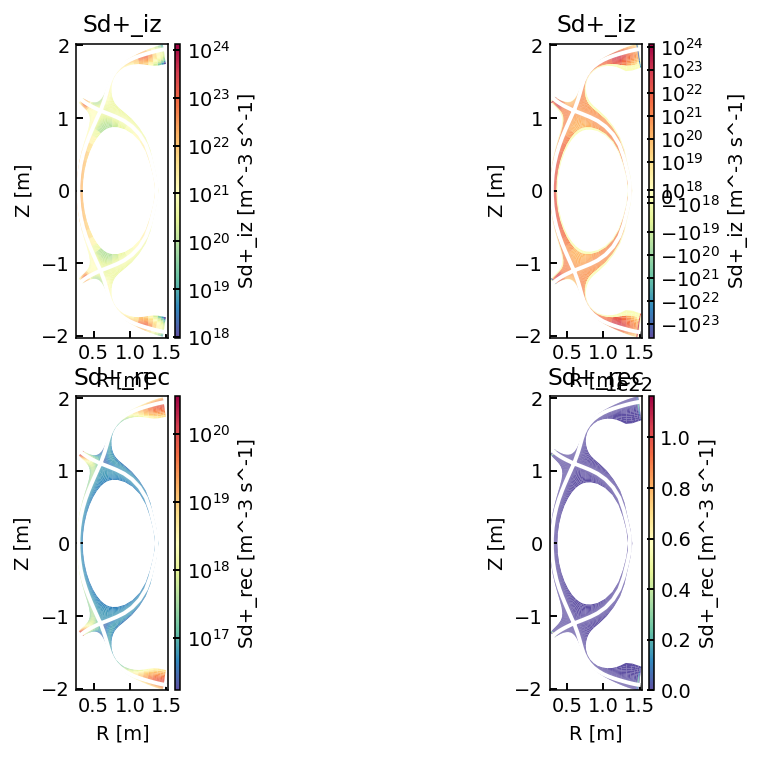

In [ ]:
ds = cs["MAST-U"].ds.isel(t=-1)
fig, ax = plt.subplots(2,2, figsize=(8,6))


ds["Sd+_iz"].hermesm.clean_guards().bout.polygon(ax = ax[0,0], cmap = "Spectral_r", antialias = True, logscale = True )
ds["Sd+_iz"].bout.polygon(ax = ax[0,1], cmap = "Spectral_r", antialias = True, logscale = True )

np.abs(ds["Sd+_rec"]).hermesm.clean_guards().bout.polygon(ax = ax[1,0], cmap = "Spectral_r", antialias = True, logscale = True )
np.abs(ds["Sd+_rec"]).bout.polygon(ax = ax[1,1], cmap = "Spectral_r", antialias = True)



for i, j in range (0,2):
    ax[i, j].set_ylim(-2.1, -0)


